# Artificial system example

This is an example notebook for the https://gitlab.com/m-c-moore/bva project.

In [1]:
import numpy as np
import scipy.stats as stats

from src.mock import additive_gaussian_snr, gen_mdof_walls, low_pass_butter
from src.sample import *
from src.simulate import AlphaConverter, CompoundConverter, LogConverter, NewmarkSimulator
from src.plot import *
from src.utils import fft, fft_axis, MeasureType

%matplotlib notebook

## Simulate observations

Define an artificial three degree-of-freedom system. We excite mass 1 and observe mass 3.

![System](img/3dof_system.svg)

In [2]:
exc_point, obs_point = 0, 2
mdof = gen_mdof_walls([1, 1, 1], [1.5, 0.5, 0.5, 1.5], [200, 600, 600, 200])
p = mdof.p
omega, zeta, alpha = mdof.modal_params(exc_point, obs_point)

with np.printoptions(formatter={"float": "{:<8.4g}".format}):
    print("Natural frequencies: ", omega)
    print("Damping ratios:      ", zeta)
    print("Modal constants:     ", alpha)

Natural frequencies:  [11.32    28.28    43.26   ]
Damping ratios:       [0.04091  0.03536  0.02396 ]
Modal constants:      [0.3074   -0.5     0.1926  ]


Define an impulse input, $u$.

In [3]:
N = 200    # number of observations
dt = 0.01  # time step in seconds
t = np.arange(0, N) * dt
U = np.zeros((p, N))
U[exc_point, 5] = 1

Simulate the output of the system and add some noise (such that the SNR is 2). These will be our observations, $x$.

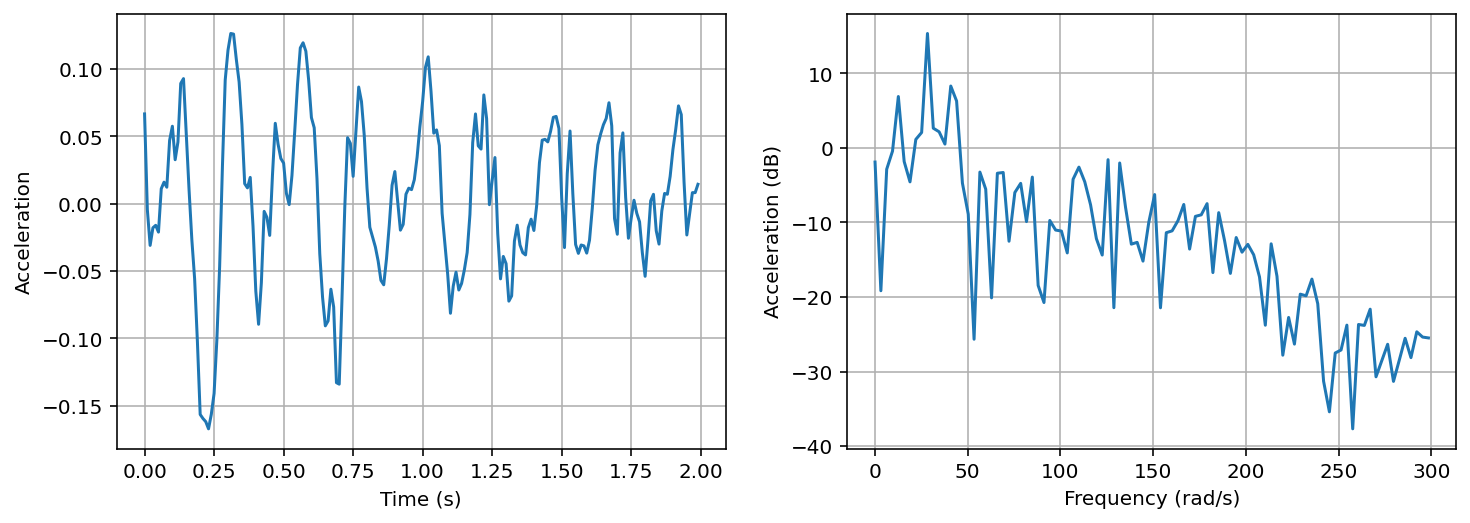

In [4]:
np.random.seed(1)

measure = MeasureType.acc  # observe acceleration data
z = mdof.simulate(U, t, exc_point, obs_point, measure)
x = additive_gaussian_snr(z, snr=2, db=False)
x = low_pass_butter(x, dt, cutoff=4*max(omega)/(2*np.pi), order=2)

w = fft_axis(t)
tf = fft(x) / fft(U[exc_point])
plot_td_fd(t, x, w, tf, fmax=300, measure=measure)

## Define the model and priors

Define the converter, which transforms the modal parameters into a suitable parameter vector:

$$
[\boldsymbol{\omega}_{n},\boldsymbol{\zeta}_{n},\boldsymbol{\alpha}_{n},\log_{10}\sigma_{v}^{2}]^{T}
\quad\rightarrow\quad \left[\boldsymbol{\omega}_{n},\log_{10}\boldsymbol{\zeta}_{n},\frac{\boldsymbol{\alpha}_{n}}{2\boldsymbol{\zeta}_{n}},\log_{10}\sigma_{v}^{2}\right]^{T} = \boldsymbol{\theta}
$$

In [5]:
converter = CompoundConverter(
    [LogConverter(np.arange(3*p+1)//p == 1), AlphaConverter(measure)]
)
simulator = NewmarkSimulator(converter, t, U, exc_point, obs_point, measure)

Make a note of the true parameter values.

In [6]:
theta_true = converter.to_theta(np.concatenate((omega, zeta, alpha, [np.log10(np.var(z - x))])))

Define prior bounds. Note that we define bounds in terms of $\alpha / 2\zeta$ so will only use the first converter.

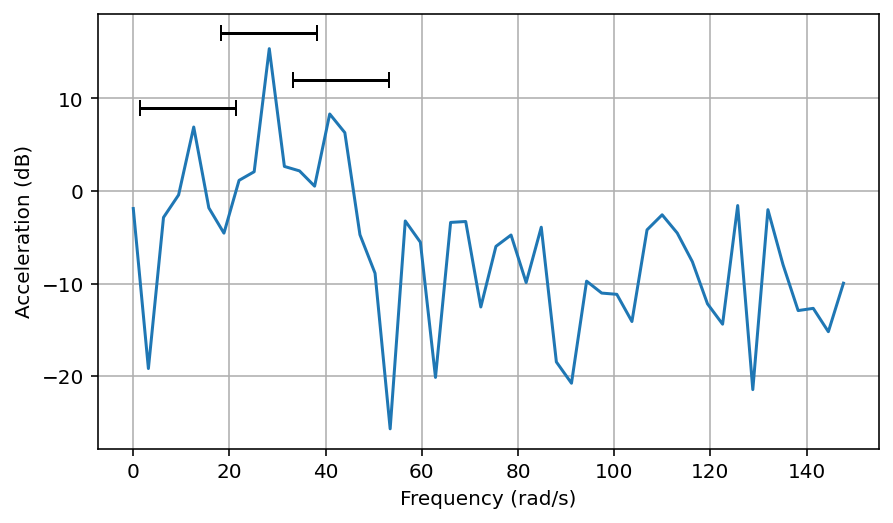

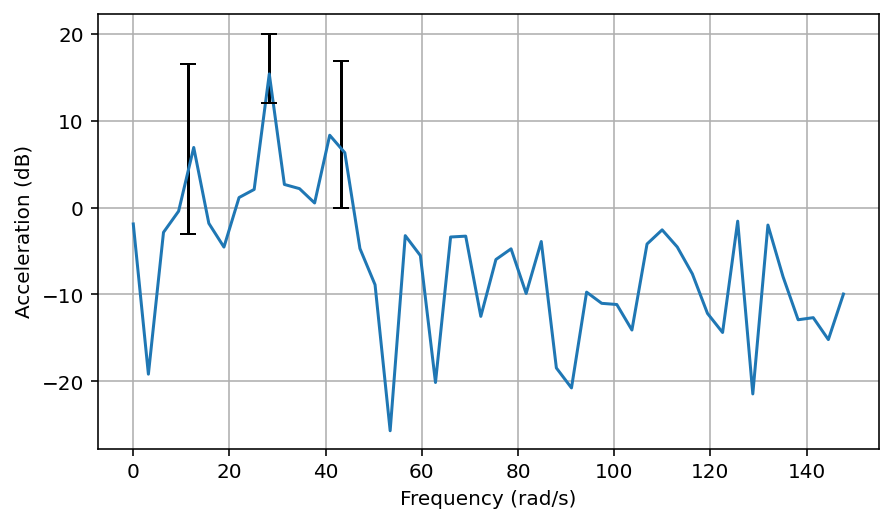

In [7]:
params_lb = np.array([ 1.32, 18.28, 33.26] + [1e-4] * 3 + [0.7, -10, 1] + [-6])
params_ub = np.array([21.32, 38.28, 53.26] + [0.2 ] * 3 + [6.7, -4 , 7] + [ 0])

lb, ub = params_lb[:3], params_ub[:3]
plot_omega_bounds(w, tf, (ub+lb)/2, (ub-lb)/2, [9, 17, 12], dict(fmax=150, measure=measure))

lb, ub = params_lb[6:9], params_ub[6:9]
plot_alpha_bounds(w, tf, (ub+lb)/2, (ub-lb)/2, omega, dict(fmax=150, measure=measure))

Define the posterior distribution from the prior and likelihood. The likelihood assumes Gaussian noise in the observations with a variance $\sigma_v^2$, which is defined by the parameter vector.

In [8]:
log_prior = UniformLogPrior(converter[0].to_theta(params_lb), converter[0].to_theta(params_ub))
log_lik = LogObsLik(x, simulator, GaussianNoiseLogVar())
log_post = LogPosterior(log_prior, log_lik)

assert not np.isinf(log_post(theta_true)), "True values should be within the prior bounds!"

## Initialise and run the sampler

Initialise the custom interface to the [emcee sampler](https://github.com/dfm/emcee). Starting points are sampled from the prior. This can be run on a parallel machine using:

---
```py
from multiprocessing import Pool

with Pool() as pool:
    sampler = EMCEESampler(log_post, total_samples, initial_thetas, pool=pool)
    sampler.run(seed=1, show_progress=True)
```
---

A multi-chain Robust Adaptive Metropolis sampler can be initialised using:

---
```py
sampler = MultiChainMCMCSampler(
    log_post, total_samples, initial_thetas, RAMSampler, initial_cov=np.eye(len(theta_true))
)
```
---

It is recommended to use the RAM sampler with fewer walkers (10-20).

In [9]:
initial_thetas = log_prior.sample(200, seed=1)  # 200 walkers
total_samples = 100_000
sampler = EMCEESampler(log_post, total_samples, initial_thetas)

In [10]:
sampler.run(seed=1, show_progress=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:21<00:00,  6.10it/s]


## Analyse the samples

### Assess convergence

Plot parameter evolution of some chains.

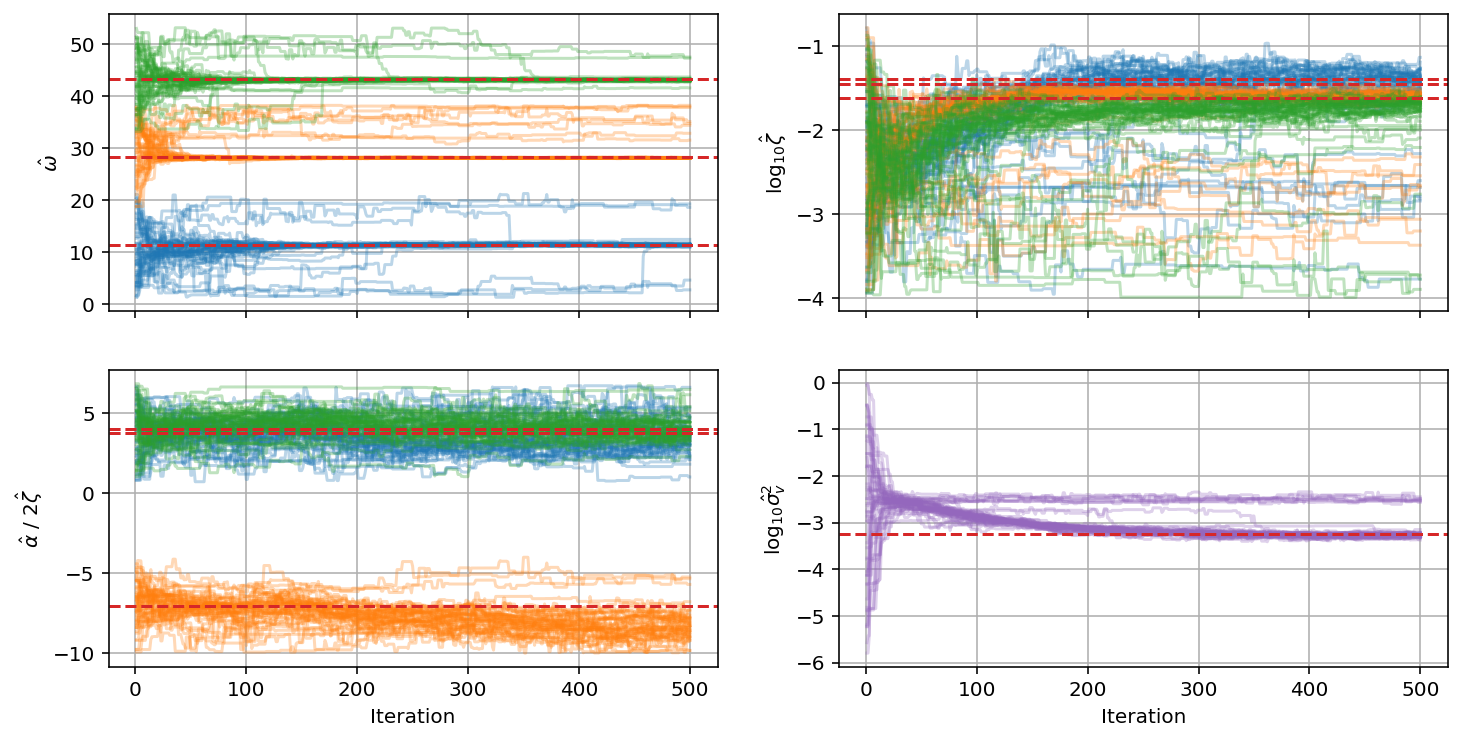

In [11]:
sampler.burn_in = 0
sampler.thin = 1
sampler.chain = tuple(range(50))
plot_sample_lines(sampler.samples, theta_true=theta_true)

Plot the evolution of the log posterior, indicating the cut-off at which chains are considered converged.

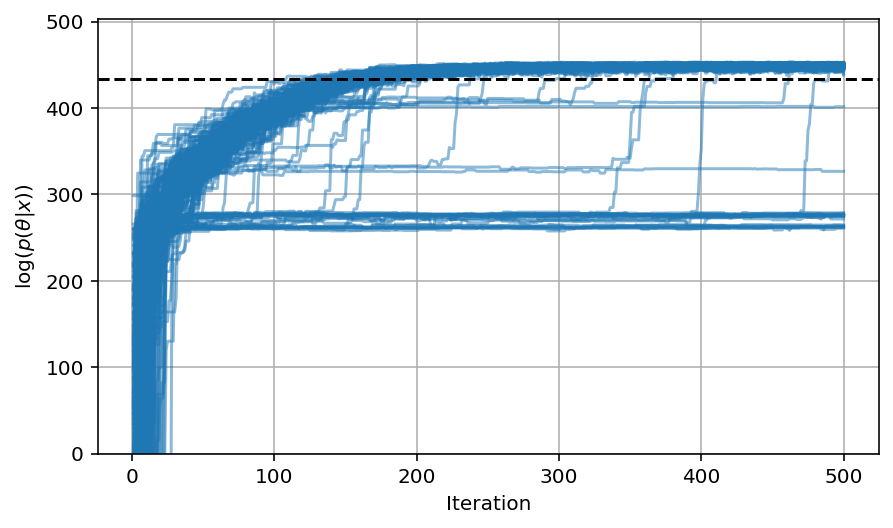

In [12]:
sampler.chain = None
lp_max = np.max(sampler.lp_samples)
lp_cutoff = lp_max - 20

plot_sample_line(
    list(sampler.lp_samples),
    colour="C0",
    alpha=0.5,
    ylim=(0, lp_max + 50),
    ylabel="$\\log(p(\\theta|x))$",
    hline=lp_cutoff,
)

Automatically burn and thin the samples to maximise the number of converged samples. This can only be done on the `EMCEESampler` - the `RAMSampler` must be burned manually.

In [13]:
sampler.auto_burn(lp_cutoff)
print(f"burn:{sampler.burn_in}, chains:{len(sampler.chain)}, samples:{len(sampler.flat_lp_samples)}")

burn:180, chains:156, samples:49920


### Plot the empirical distributions

Plot modal parameter histograms. True values are shown in red and the prior distributions in black.

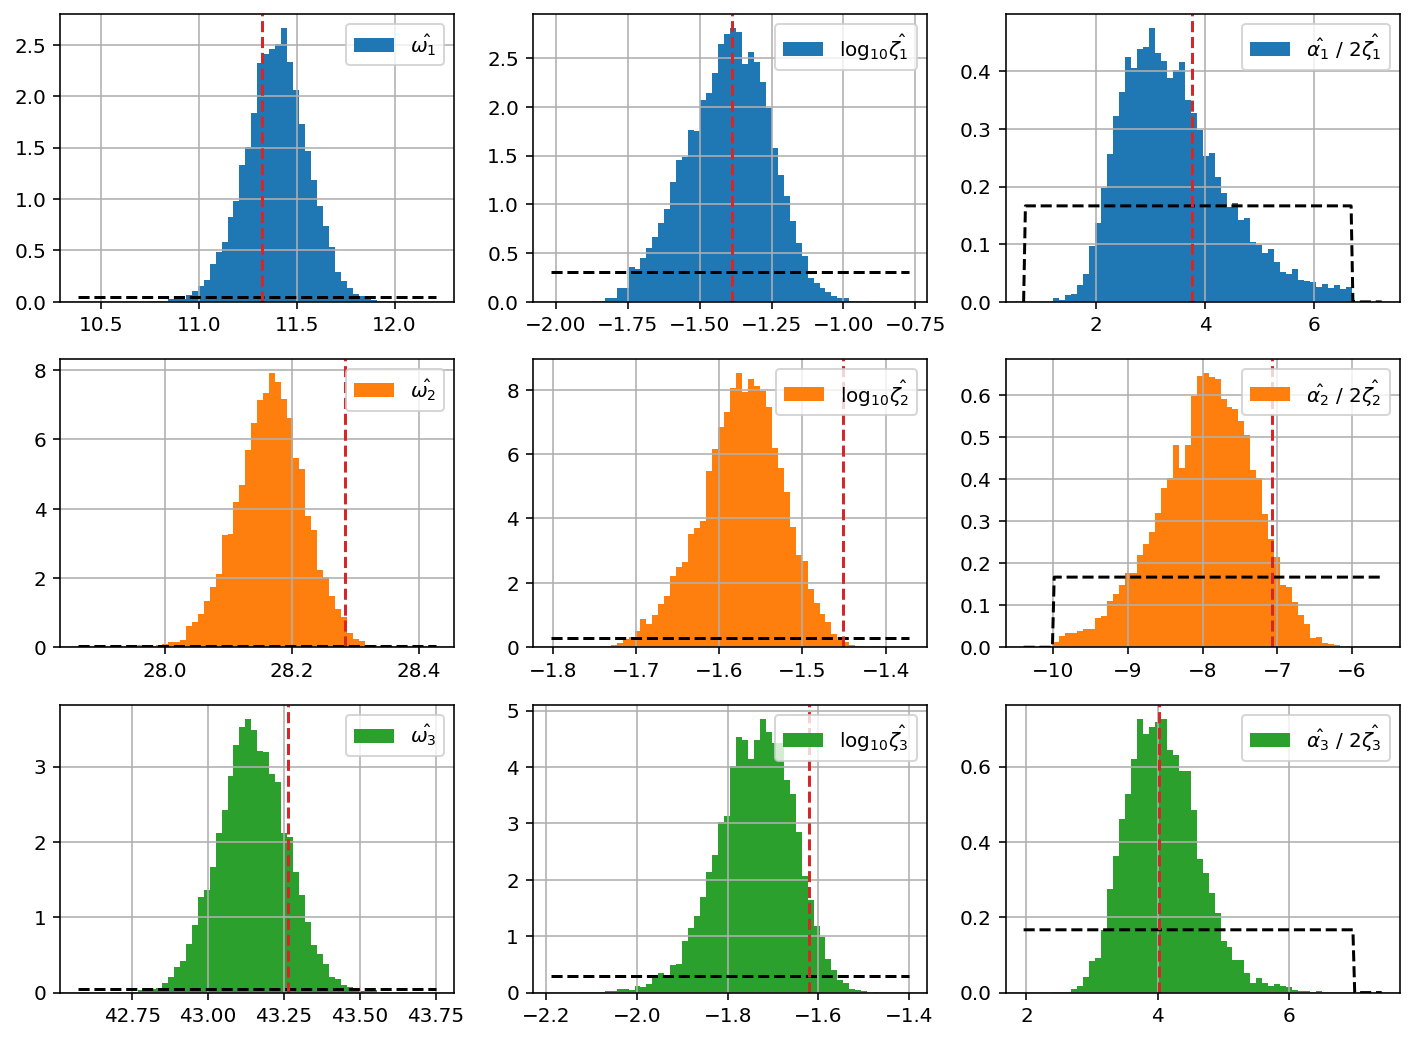

In [14]:
plot_sample_hists(
    sampler.flat_samples,
    theta_true=theta_true,
    pdf_funcs=log_prior.marg_pdfs,
    bins=50,
)

Noise variance histogram.

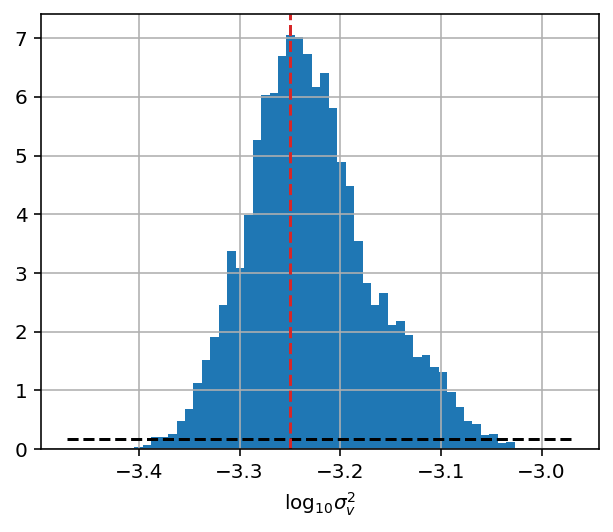

In [15]:
plot_sample_hist(
    sampler.flat_samples[:, -1],
    y_true=theta_true[-1],
    pdf_func=log_prior.marg_pdfs[-1],
    bins=50,
    xlabel="$\\log_{10}\\sigma_v^2$",
)

Plot mo histograms with join distributions.

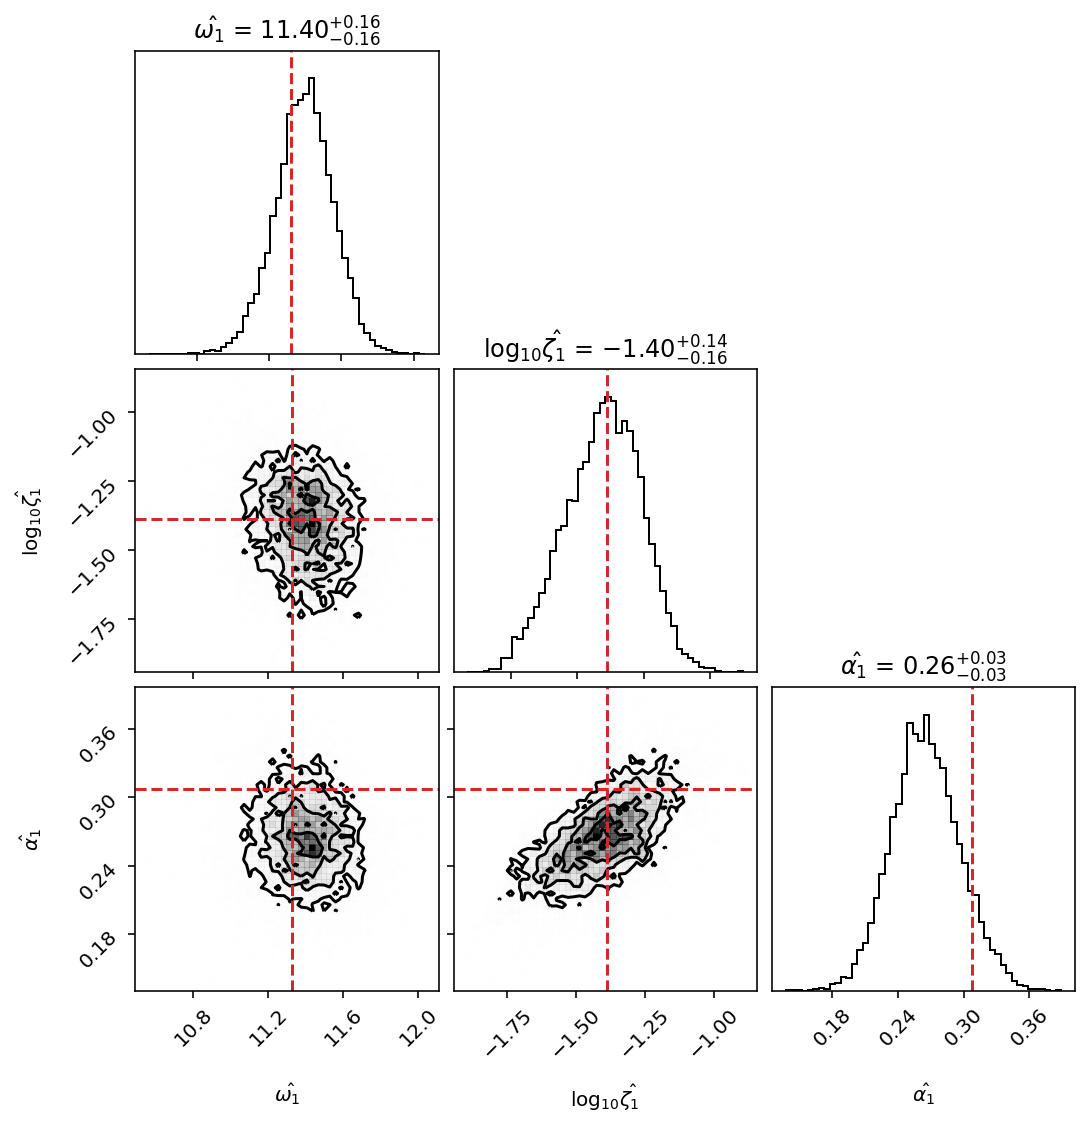

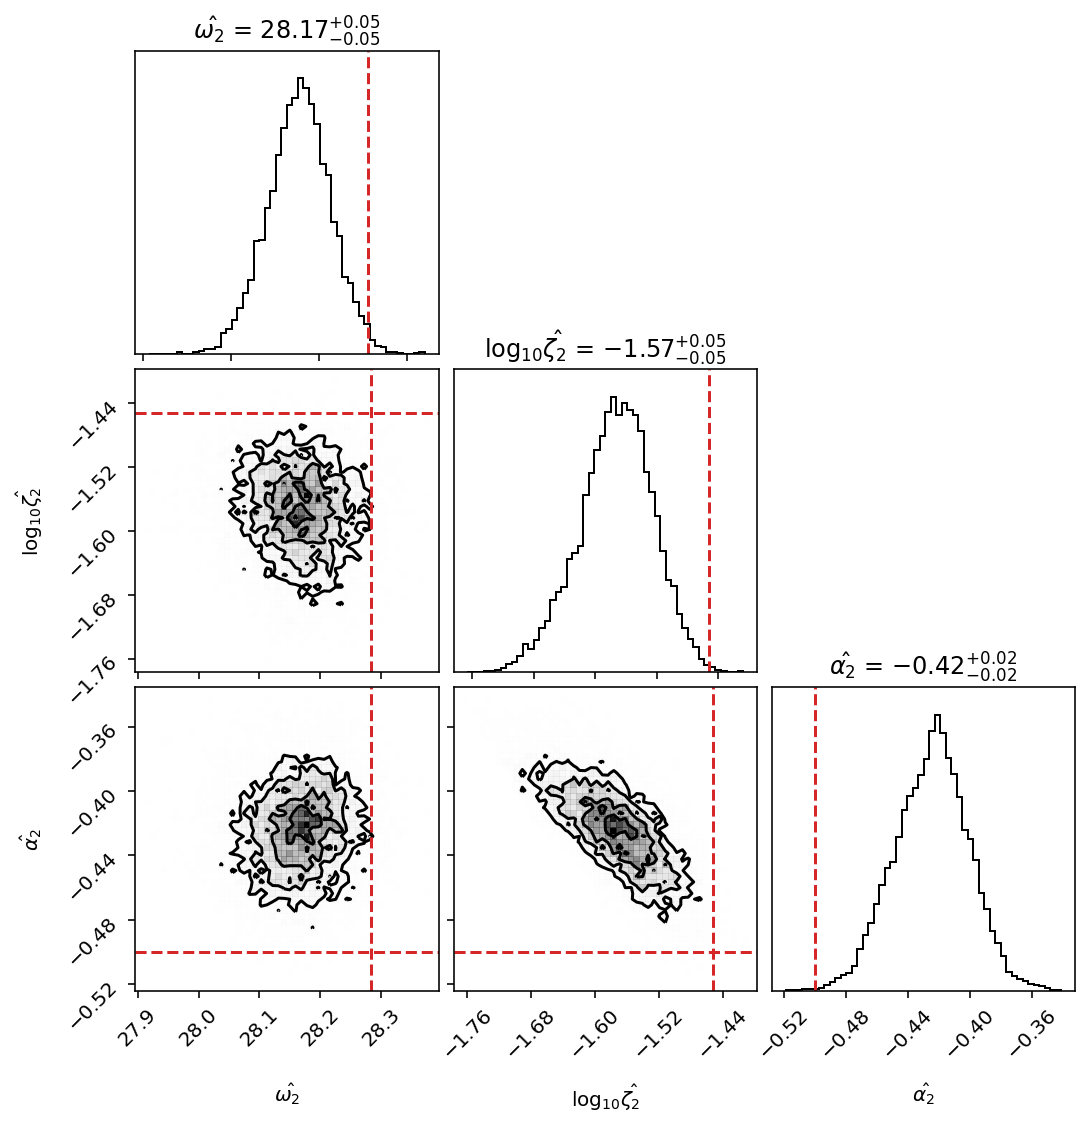

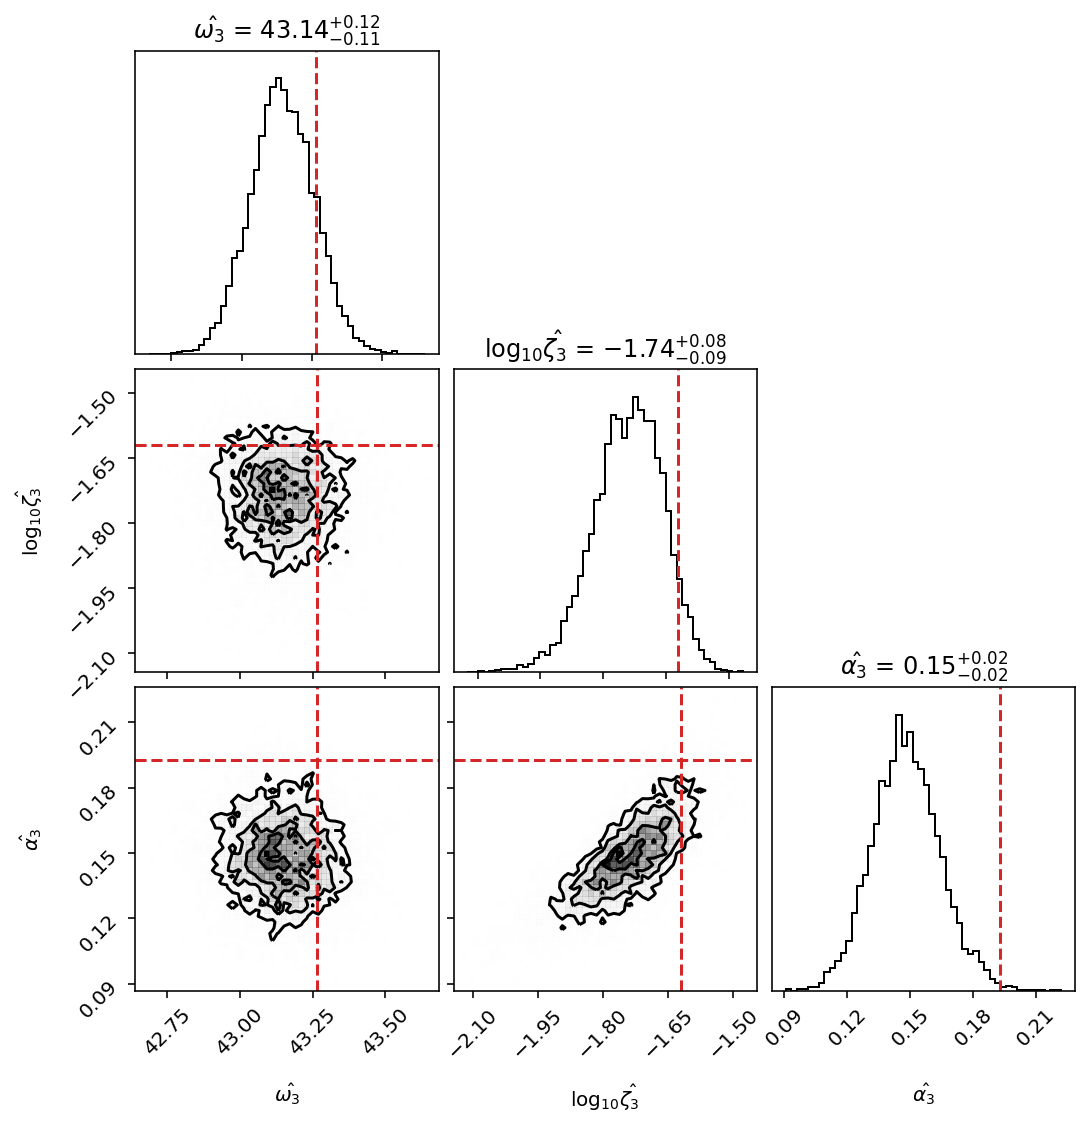

In [16]:
 plot_corner(
    sampler.flat_converted_samples(converter[1]),
    theta_true=converter[1].from_theta(theta_true),
    show_mean=False,
    bins=50,
    group_by="mode",  # one of "mode", "param" or None
    converted_alpha=True,
)

### Model evidence estimates

Laplace approximation.

In [17]:
lap_mean, lap_cov, lme = laplace_approx(
    sampler.flat_converted_samples(converter[1]),
    lambda _t: log_post(converter[1].to_theta(_t)),
)
print("Laplace approximation for the log model evidence:", lme)

Laplace approximation for the log model evidence: 432.0706682989426


Compare the Laplace approximation to the marginal distributions.

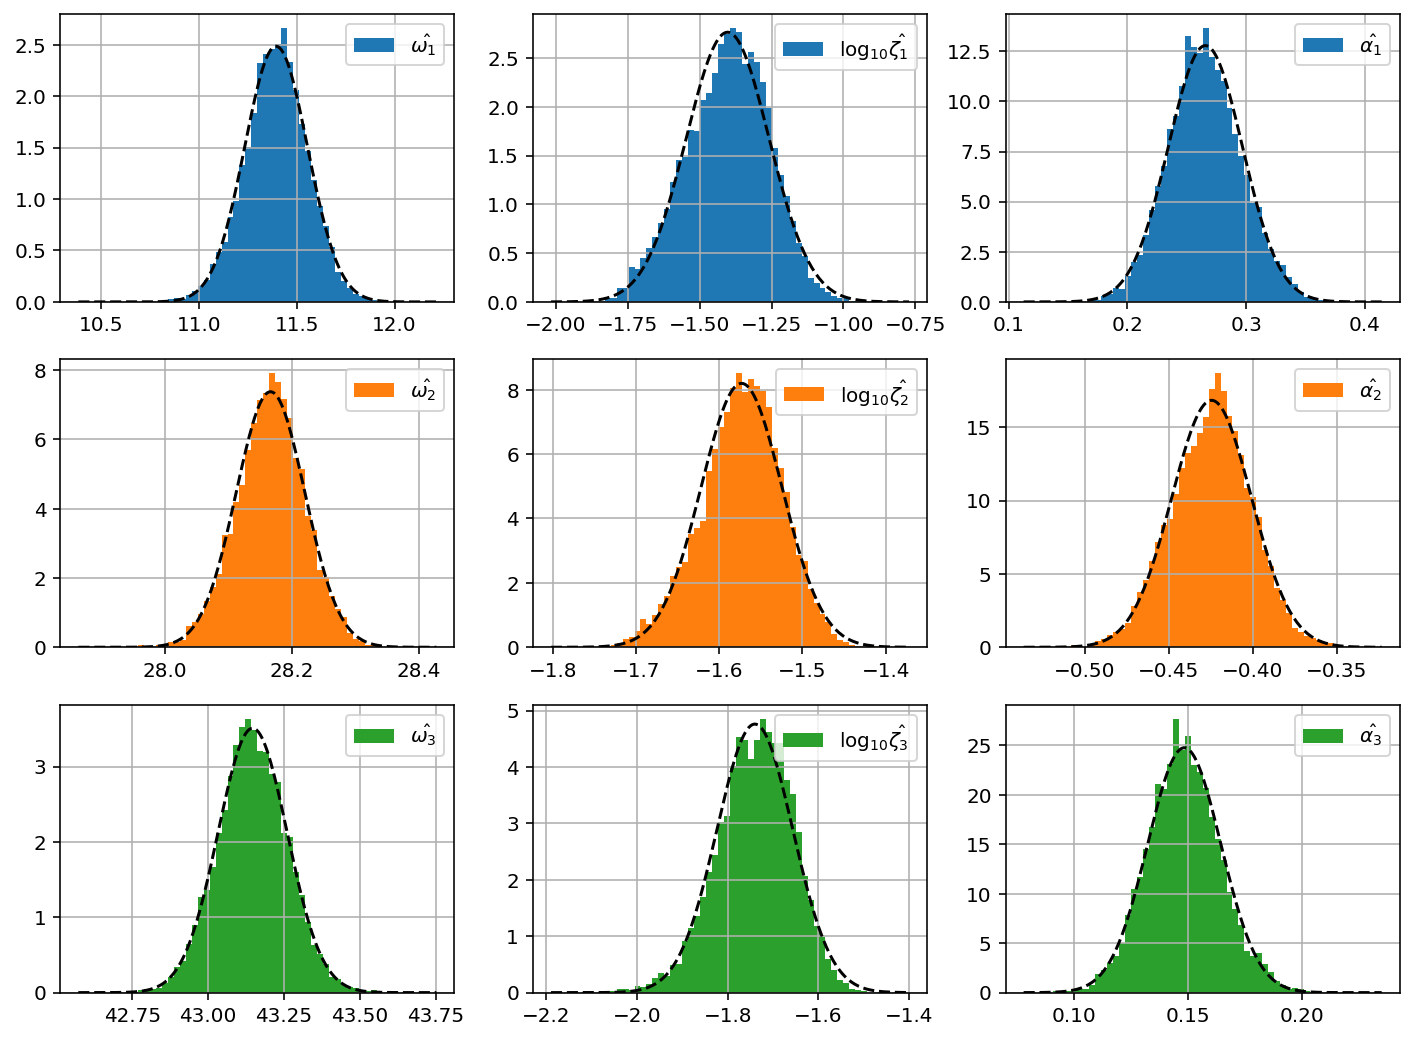

In [18]:
pdf_funcs = [stats.norm(lap_mean[i], lap_cov[i,i]**0.5).pdf for i in range(sampler.ndim-1)]
plot_sample_hists(
    sampler.flat_converted_samples(converter[1]),
    pdf_funcs=pdf_funcs,
    bins=50,
    converted_alpha=True,
)

Bayesian information criterion (less accurate).

In [19]:
bic = sampler.bayesian_information_criterion(len(x))
print("BIC approximation for the log model evidence:", -bic/2)

BIC approximation for the log model evidence: 446.6446916346481


### MAP reconstruction

Using the observed MAP estimate.

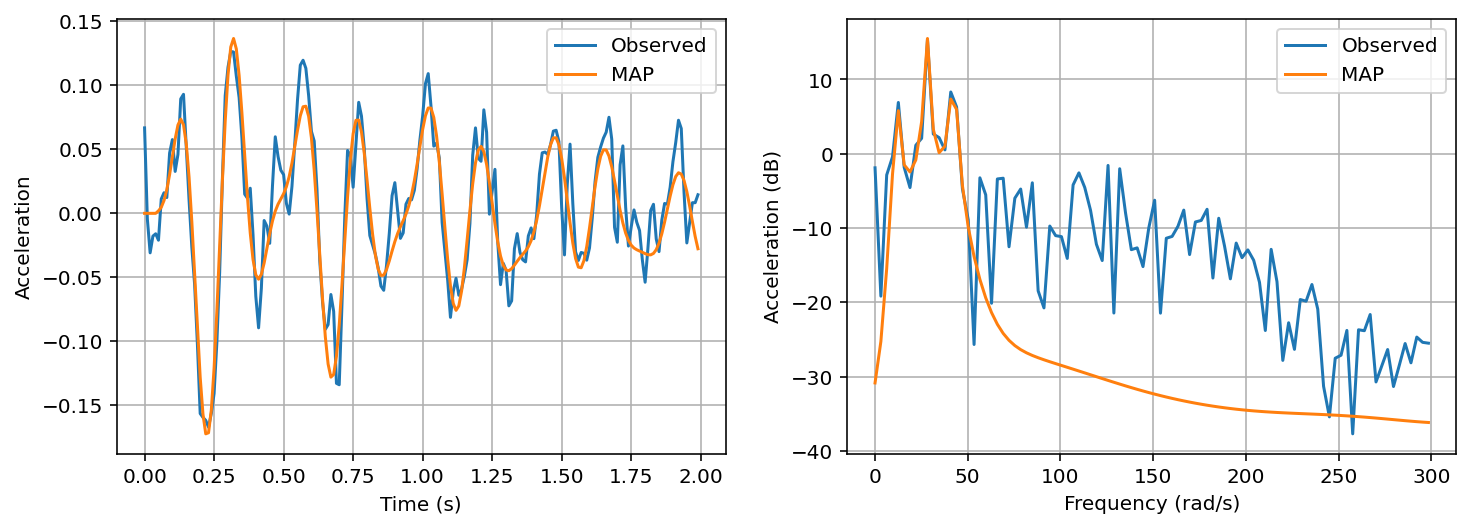

Error norm: 0.32125368034194723


In [20]:
theta_map = sampler.theta_max_all
x_map = simulator(theta_map)
u_fft = fft(U[exc_point])

plot_td_fd(
    t,
    [x, x_map],
    w,
    [tf, fft(x_map) / u_fft],
    ["Observed", "MAP"],
    fmax=300,
    measure=measure,
)
print("Error norm:", np.linalg.norm(x - x_map))

Using the optimised MAP estimate.

      fun: -453.9280267847612
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.01253966, -0.00035243,  0.00160298, -0.00699174,  0.00313207,
        0.00121645, -0.00150635,  0.00146656,  0.00106866,  0.00050022])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 583
      nit: 47
     njev: 53
   status: 0
  success: True
        x: array([11.40663125, 28.16311357, 43.14416717, -1.36762056, -1.57004802,
       -1.70202139,  3.15440864, -7.94142082,  3.85195787, -3.28957422])


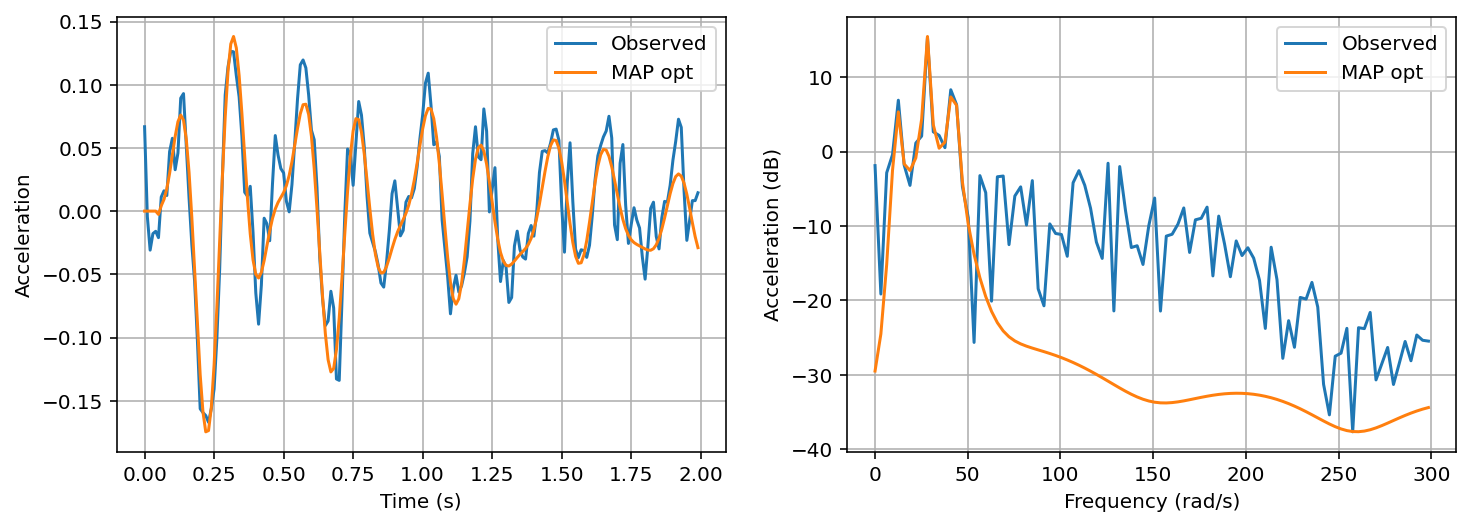

Error norm: 0.3204257574624215


In [21]:
theta_opt = sampler.theta_opt(theta_true, max_sim=5000, verbose=True)
x_opt = simulator(theta_opt)
plot_td_fd(
    t,
    [x, x_opt],
    w,
    [tf, fft(x_opt) / u_fft],
    ["Observed", "MAP opt"],
    fmax=300,
    measure=measure,
)
print("Error norm:", np.linalg.norm(x - x_opt))

### Comparison of multiple simulations

Randomly select 100 of the converged samples and compare their simulations to the observations.

In [22]:
np.random.seed(1)
indices = np.random.choice(np.arange(len(sampler.flat_lp_samples)), 100, replace=False)
samples = sampler.flat_samples[indices]
simulations = [simulator(theta) for theta in samples]

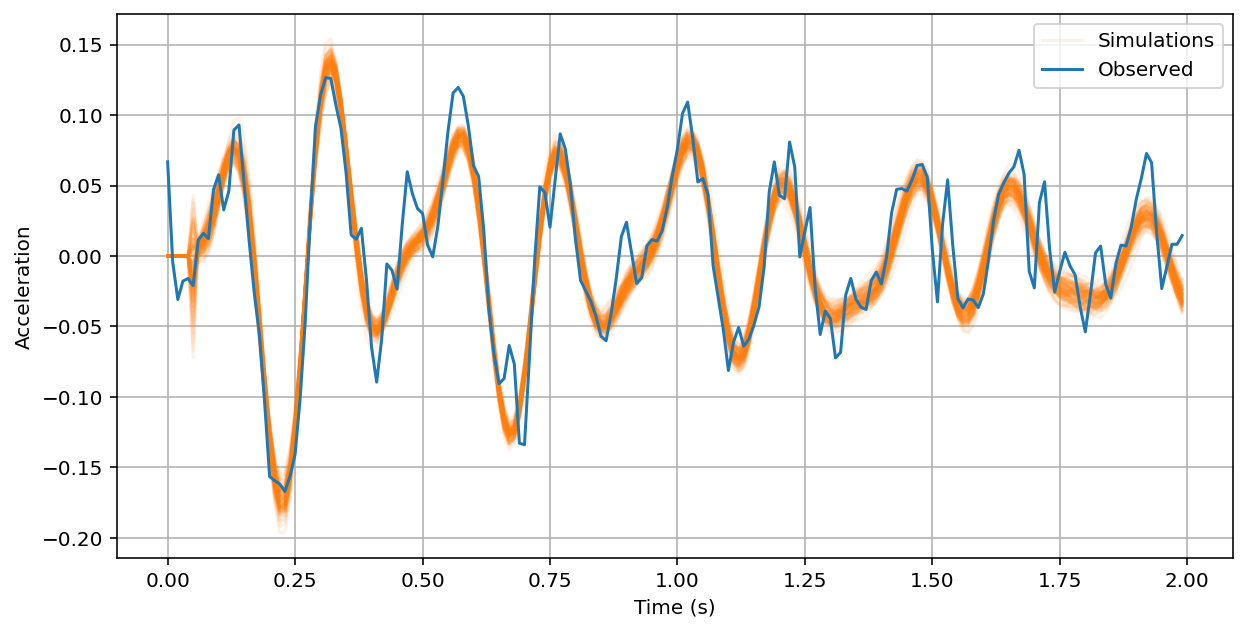

In [23]:
plot_td_sims(
    t,
    x,
    simulations,
    ["Observed", "Simulations"],
    alpha=0.1,
    measure=measure,
)

plot_fd_sims(
    w,
    tf,
    [fft(y) / u_fft for y in simulations],
    ["Observed", "Simulations"],
    fmax=300,
    alpha=0.1,
    measure=measure,
)